In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import boxcox1p
from scipy.stats import probplot, skew, pearsonr

from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.base import clone
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import logging
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#### 1. Load data

In [3]:
folderPath = "../data/"
train = pd.read_csv(folderPath + "train.csv")  
test = pd.read_csv(folderPath + "test.csv")  
print(train.shape)
train.head(2)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


#### 2. EDA
- Check missing data
- Check for outliers
- Skewness analysis of target & feature distributions
- Convert categorical coding to numerical encoding

##### Missing data ------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)

In [5]:
checkMissingData(train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- remove features with missing data > 40% & impute mean value into LotFrontage

In [6]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu', 'Fence'], axis=1, inplace = True)

- remove features with missing data > 40% & impute mean value into LotFrontage based on its own neighbourhood

In [7]:
# df_ = train.groupby(["Neighborhood"]).LotFrontage.mean()
# train[train.LotFrontage.isnull() == True].Neighborhood
# train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [8]:
checkMissingData(train)

,Total,Percent
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


- 81 'Garage' variables are missing probably reflecting those houses without a garage
        - fill with 'NotAvail'

In [9]:
garage_cols = ['GarageType','GarageFinish', 'GarageCars','GarageQual', 'GarageCond']
train[garage_cols] = train[garage_cols].fillna('NotAvail')

- Recheck updated missing data

In [10]:
checkMissingData(train)

,Total,Percent
GarageYrBlt,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000


- Scale GarageYrBlt to values between 0 and 1 and set missing values to '0' 
        - thereby having little influence as a feature as they are literally houses with no garage

In [11]:
X = train.values
ct = ColumnTransformer([("mm", MinMaxScaler(), ['GarageYrBlt'])])
train.GarageYrBlt = ct.fit_transform(train)
train.GarageYrBlt = train.GarageYrBlt.fillna(0)
checkMissingData(train)

,Total,Percent
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
RoofStyle,0,0.000000


- The missing basement & MasVnr variables are for houses presumably without basements & masonry veneers: 
        - thereby having little influence as a feature as they are literally houses with no garage
        - use same method as before: type in "NotAvail" if categorical or '0' if numeric
        - replace missing electrical value with most common type

In [12]:
cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'MasVnrArea']
train.MasVnrArea.fillna(value=0, inplace=True)
for col in cols:
    if train[col].dtype != 'object':
        train[col].fillna(value=0, inplace=True)
    else:
        train[col].fillna(value='NotAvail', inplace=True)
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [13]:
#train[train['BsmtExposure']].fillna(value='NotAvail', inplace=True)
train.Electrical.fillna(value='SBrkr', inplace=True)
checkMissingData(train).head(1)

,Total,Percent
SalePrice,0,0.0


*No more missing data*

##### Outlier detection for continuous variables --------------------------------------------------------------------------------------------------------------------------------

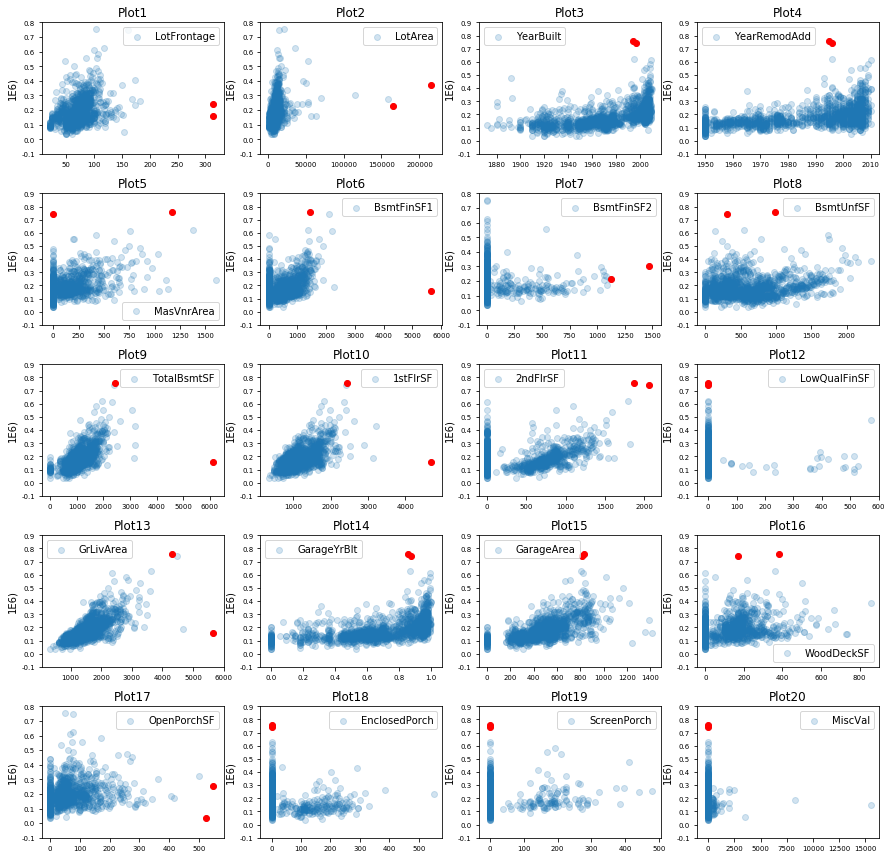

In [14]:
colList = []
count = 0
for i, col in enumerate(train.columns):
    if (i != 0) & (train[col].dtype != 'O') & (col != 'SalePrice'):
        # Only consider continous variables
        if len(train[col].value_counts()) > 20:
            colList.append(col)
            count += 1

rows = int(np.ceil(len(colList) / 4))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    #print(col)
    axi = f.add_subplot(rows, 4, i+1)
    plt.scatter(train[col], train.SalePrice, label = col, alpha = 0.2)
    df = train[[col, 'SalePrice']]
    X = df.values
    elenv = EllipticEnvelope(contamination=.001)
    pred = elenv.fit_predict(X)
    anom_index = np.where(pred==-1)
    values = X[anom_index]

    plt.scatter(values[:,0],values[:,1], color='r')
    plt.title("Plot" + str(i+1))
    axi.tick_params(axis="x", labelsize=7)
    axi.tick_params(axis="y", labelsize=7)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    plt.ylabel('1E6)')
    plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

*Assuming a contamination of outliers in the dataset of 0.1% the above red datapoints have been suggested as outliers according to sklearn's "elliptic envelope"* <br> From the above plots it seems only appropriate to consider those in plots 1, 2, 6, 9, 10, 13, 17, 20"  

In [15]:
train_ = train.copy()
# Plot1
train_ = train_[(train_.LotFrontage < 300)]
# Plot2
train_ = train_[(train_.LotArea < 150000)]
# Plot6
train_ = train_[(train_.BsmtFinSF1 < 5000)]   
# Plot9
train_ = train_[(train_.TotalBsmtSF < 6000)]  
# Plot10
train_ = train_[(train_['1stFlrSF'] < 4000)]    
# Plot13
train_ = train_[(train_.GrLivArea < 5000)]    
# Plot17
train_ = train_[(train_.OpenPorchSF < 500)]   
# Plot20
train_ = train_[(train_.MiscVal < 15000)]

# Examine size of data with outliers removed vrs those without
print('Deleted {} points.'.format(train.shape[0] - train_.shape[0]))
train.shape, train_.shape                                      

Deleted 9 points.


((1460, 76), (1451, 76))

##### Check skewness of target variable --------------------------------------------------------------------------------------------------------------------------------------------
        - correct with log of target

In [16]:
def plotDistrib(df_):
    df = df_.copy()
    f = plt.figure(figsize=(15,4))
    label_ = 'original'
    for i in range(0, 4):
        axi = f.add_subplot(2, 2, i+1)
        if i%2 == 0:
            sns.distplot(df['SalePrice'], ax= axi)#label = label_)
        else:
            res = probplot(df['SalePrice'], plot=axi)#label = label_)
        
        plt.legend(title=label_, loc='upper left')
        if i == 1:
            label_ = 'log_transform'
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            df["SalePrice"] = np.log(df['SalePrice'])
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            
        #, labels=['Hell Yeh', 'Nah Bruh'])
            
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.60)

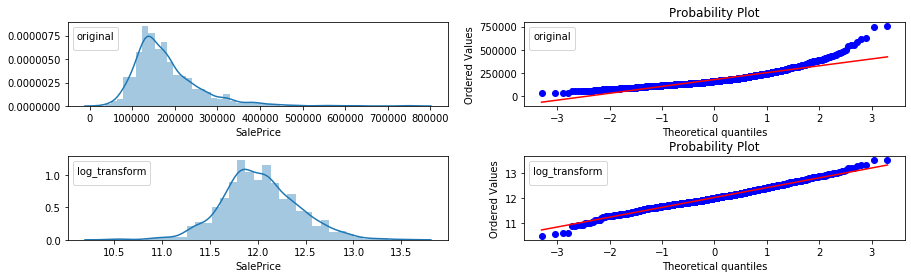

In [17]:
train = train_.copy()
plotDistrib(train_)
train['SalePrice'] = np.log(train_['SalePrice'])
train_ = train.copy()

##### Check skewness of continous features: -----------------------------------------------------------------------------------------------------------------------------------
*'If you log transform the response variable, it is required to also log transform feature variables that are skewed."* <br>
https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

In [18]:
# Check the skew of all continuous features ('colList' defined above)
def checkSkewness(df, colList_):
    skewed_feats = df[colList_].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features:")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    return skewness

In [19]:
skewDf = checkSkewness(train, colList)
skewDf.head()


Skew in numerical features:


,Skew
MiscVal,19.725720
LowQualFinSF,8.973279
LotArea,6.266328
BsmtFinSF2,4.274151
ScreenPorch,4.006622


*Box-Cox transformation 'boxcox1p' to attempt removal of some skewness*

In [20]:
df = train.copy()

In [21]:
train = df.copy()

In [22]:
skewDf = skewDf[abs(skewDf.Skew) > 2] ## Assume skewness level above 2 is considered
#print("There are {} relatively skewed numerical features to Box Cox transform".format(skewDf.shape[0]))

skewed_features = skewDf.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

# Check the skew of updated features
skewDf = checkSkewness(train, colList)
skewDf.head(5)


Skew in numerical features:


,Skew
LowQualFinSF,7.568654
MiscVal,5.576180
ScreenPorch,3.185447
BsmtFinSF2,2.629567
EnclosedPorch,2.159021


In [23]:
df = train.copy()
train_ = train.copy()

*Skewness has been reduced to more reasonable levels*

##### Build various datasets: ----------------------------------------------------------------------------------------------------------------

*Various representations of categorical features will be explored*
    - numerical encoding, binary encoding and one-hot encoding

*Categorical to numerical encoding:*

In [24]:
cat_vars = train.dtypes[train.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    #print(var)
    train[var] = train[var].astype('category')
    train[var] = train[var].cat.codes

    Keep backup of original numerical-encoded train

In [25]:
train_num = train.copy()
train = train_.copy()

*Convert to Binary encoding:* 

In [26]:
# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=cat_vars.values.tolist()).fit(train)
# transform the dataset
train_bin = enc.transform(df)
print(train_bin.shape)
train_bin.head(2)

(1451, 183)


,Id,MSSubClass,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,LotFrontage,LotArea,Street_0,Street_1,LotShape_0,LotShape_1,LotShape_2,LandContour_0,LandContour_1,LandContour_2,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition2_0,Condition2_1,Condition2_2,Condition2_3,BldgType_0,BldgType_1,BldgType_2,BldgType_3,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrArea,ExterQual_0,ExterQual_1,ExterQual_2,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinSF1,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating_0,Heating_1,Heating_2,Heating_3,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual_0,KitchenQual_1,KitchenQual_2,TotRmsAbvGrd,Functional_0,Functional_1,Functional_2,Functional_3,Fireplaces,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageYrBlt,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageCars,GarageArea,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,PavedDrive_0,PavedDrive_1,PavedDrive_2,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SalePrice
0,1,60,0,0,0,1,65.0,19.212182,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,7,5,2003,2003,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,8.059126,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,706,0,0,0,1,0.0,150,856,0,0,0,1,0,0,0,1,0,1,0,0,0,1,856,854,0.0,1710,1,0,2,1,3,1,0,0,1,8,0,0,0,1,0,0,0,0,1,0.936364,0,0,1,2,548,0,0,0,1,0,0,0,1,0,0,1,0,61,0.0,0,0.0,0,0.0,2,2008,0,0,0,0,1,0,0,0,1,12.247694
1,2,20,0,0,0,1,80.0,19.712205,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,6,8,1976,1976,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.000000,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,978,0,0,0,1,0.0,284,1262,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1262,0,0.0,1262,0,1,2,0,3,1,0,1,0,6,0,0,0,1,1,0,0,0,1,0.690909,0,0,1,2,460,0,0,0,1,0,0,0,1,0,0,1,298,0,0.0,0,0.0,0,0.0,5,2007,0,0,0,0,1,0,0,0,1,12.109011


*Convert to One-hot encoding:*

In [27]:
train_one = train_num.copy()
for i, var in enumerate(cat_vars):
    temp = pd.get_dummies(train_one[var],prefix=var, drop_first = True )
    train_one = pd.concat([train_one,temp], axis=1)
    train_one.drop(var, axis=1, inplace = True)

print(train_one.shape)
train_one.head(2)

(1451, 242)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_1,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,Utilities_1,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_1,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,1,60,65.0,19.212182,7,5,2003,2003,8.059126,706,0.0,150,856,856,854,0.0,1710,1,0,2,1,3,1,8,0,0.936364,2,548,0,61,0.0,0,0.0,0,0.0,2,2008,12.247694,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,19.712205,6,8,1976,1976,0.000000,978,0.0,284,1262,1262,0,0.0,1262,0,1,2,0,3,1,6,1,0.690909,2,460,298,0,0.0,0,0.0,0,0.0,5,2007,12.109011,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

*Scaled datasets of all types*

In [28]:
# 1. Standardised Dataset
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    X = df.drop(['SalePrice'], axis = 1).values
    scaledX = mm.fit_transform(X)
    df_scaled = pd.DataFrame(scaledX, columns=df.columns[:-1])
    df_scaled['SalePrice'] = df.SalePrice
    return df_scaled

In [29]:
train_one_scaled = scaleData(train_one)
train_bin_scaled = scaleData(train_bin)
train_num_scaled = scaleData(train_num)

In [30]:
train_num_scaled.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.000000,0.235294,0.75,0.273292,0.337851,1.0,1.0,1.0,0.0,1.0,0.0,0.208333,0.250,0.333333,0.0,0.714286,0.666667,0.500,0.949275,0.883333,0.2,0.0,0.857143,0.866667,0.25,0.597109,0.666667,1.0,0.4,0.5,1.0,0.75,0.333333,0.312389,1.0,0.0,0.064212,0.266999,0.2,0.0,1.0,1.0,0.180373,0.413559,0.0,0.316905,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.500000,1.0,0.000000,0.166667,0.936364,0.666667,0.5,0.394245,1.0,1.0,1.0,0.000000,0.145933,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8,12.247694
1,0.000685,0.000000,0.75,0.366460,0.364526,1.0,1.0,1.0,0.0,0.5,0.0,1.000000,0.125,0.333333,0.0,0.285714,0.555556,0.875,0.753623,0.433333,0.2,0.0,0.571429,0.533333,0.50,0.000000,1.000000,1.0,0.2,0.5,1.0,0.25,0.000000,0.432743,1.0,0.0,0.121575,0.393637,0.2,0.0,1.0,1.0,0.320663,0.000000,0.0,0.213726,0.000000,0.5,0.666667,0.0,0.375,0.333333,1.000000,0.333333,1.0,0.333333,0.166667,0.690909,0.666667,0.5,0.330935,1.0,1.0,1.0,0.347725,0.000000,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8,12.109011


##### Visualise highest Pearson's coefficient correlations with 'SalePrice': -----------------------------------------------------------------------------------------------

In [31]:
def checkTargetVarCorrel(df):
    lstCorrelRanks = []
    for i, col in enumerate(df):
        if col != 'SalePrice':
            #print(type(df[col].values[0]), col)
            pearson_coeff = round(pearsonr(df['SalePrice'], df[col])[0], 2)
            lstCorrelRanks.append([col, pearson_coeff, df[col].dtype])
            #print(col, pearson_coeff)
    df_correl = pd.DataFrame(lstCorrelRanks, columns = ['Var', 'Value', 'DataType'])
    df_correl.sort_values(by = 'Value', ascending = False, inplace = True)
    df_correl.reset_index(drop = True, inplace = True)
    return df_correl

In [32]:
# Most positively correlated with 'SalePrice'
df_correl = checkTargetVarCorrel(train_num)
df_correl.head()

,Var,Value,DataType
0,OverallQual,0.82,int64
1,GrLivArea,0.72,int64
2,GarageCars,0.68,int64
3,GarageArea,0.66,int64
4,TotalBsmtSF,0.64,int64


In [33]:
# Most negatively correlated with 'SalePrice'
df_correl = checkTargetVarCorrel(train_num)
df_correl.sort_values(by = 'Value', ascending = True, inplace = True)
df_correl.head()

,Var,Value,DataType
74,ExterQual,-0.59,int8
73,BsmtQual,-0.58,int8
72,KitchenQual,-0.54,int8
71,GarageType,-0.50,int8
70,HeatingQC,-0.43,int8


##### Multicollinearity within datasets: ----------------------------------------------------------------------------------------------------------------

*There is certainly a real risk of multicollinearity between features within these datasets. For example 'Garage' variables alone will be highly correlated with eachother.*<br>
In order to reduce this risk, tree-based algorithms will only be used in the presence of features with multi-collinearity. Otherwise for algorithms susceptible to this problem (i.e. linear regression), preprocessing on the dataset via PCA-based feature reduction will be introduced. Algorithms with susceptibility to multicollinearity will only be subject to the PCA-reduced dataset.
*Here several approaches will be demonstrated:* <br>

1. Datasets with PCA-based feature reduction to remove multicollinearity
2. Original datasets for tree-based algorithms that do not exhibit same risks of multicollinearity
3. Tree-based algorithms will also be trialed on the PCA-datasets

#### 3. Machine Learning

- Helper Methods
        - Hyperparameter-tuning & train-test splits <br>
*Hyperparameter tuning completed via Bayesian Optimisation*        

In [58]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False):
    
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        print(round(rmsleScore, 2), end = ', ')

    print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)

## -----------------------------------------------------------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    return cval.mean()

#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------
def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    

#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(max_depth),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(n_estimators)
        }
        mdl = RandomForestRegressor(**params_)
        return -run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=50)

    print("Final result:", optimizer.max)
    return optimizer.max

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return -run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=50)

    print("Final result:", optimizer.max)
    return optimizer.max

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
        }
        mdl = LGBMRegressor(**params_)
        return -run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=50)

    print("Final result:", optimizer.max)
    return optimizer.max

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(max_depth),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
        }
        mdl = GradientBoostingRegressor(**params_)
        return -run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=1)

    print("Final result:", optimizer.max)
    return optimizer.max

##### Numerical features datasets: ----------------------------------------------------------------------------------------------------------------

- **Without PCA: Only tree-based models**

i.a. Try Random Forest without scaling (Hyperparameter tuning

In [36]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_opt_rf_unscaled = optimiseRF(train_num.copy(), bounds_)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        |  0.01723  |  44.62    |  0.007203 |  50.02    |
|  2        |  0.01365  |  33.72    |  0.001468 |  68.47    |
|  3        |  0.01546  |  22.69    |  0.003456 |  129.4    |
|  4        |  0.01591  |  56.19    |  0.004192 |  187.0    |
|  5        |  0.01756  |  24.42    |  0.008781 |  55.48    |
|  6        |  0.01594  |  68.69    |  0.004173 |  161.7    |
|  7        |  0.01411  |  18.34    |  0.001981 |  210.1    |
|  8        |  0.01514  |  96.98    |  0.003134 |  188.5    |
|  9        |  0.01765  |  88.26    |  0.008946 |  67.01    |
|  10       |  0.01383  |  8.71     |  0.001698 |  225.6    |
|  11       |  0.01596  |  99.9     |  0.004082 |  50.2     |
|  12       |  0.01493  |  99.59    |  0.002896 |  50.51    |
|  13       |  0.01483  |  99.74    |  0.002762 |  50.14    |
|  14       |  0.01688  |  5.051    |  0.006243 |  50.74    |
|  15   

i.b. Try Random Forest with scaling (Hyperparameter tuning)

In [40]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(1,100)
             }
max_opt_rf_scaled = optimiseRF(train_num_scaled.dropna().copy(), bounds_)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        |  0.0306   |  42.29    |  0.007203 |  50.02    |
|  2        |  0.03084  |  30.93    |  0.001468 |  68.47    |
|  3        |  0.03069  |  19.44    |  0.003456 |  129.4    |
|  4        |  0.03064  |  54.34    |  0.004192 |  187.0    |
|  5        |  0.03045  |  21.24    |  0.008781 |  55.48    |
|  6        |  0.03066  |  67.38    |  0.004173 |  161.7    |
|  7        |  0.03077  |  14.9     |  0.001981 |  210.1    |
|  8        |  0.03071  |  96.86    |  0.003134 |  188.5    |
|  9        |  0.03045  |  87.76    |  0.008946 |  67.01    |
|  10       |  0.0307   |  4.866    |  0.001698 |  225.6    |
|  11       |  0.03061  |  99.53    |  0.005485 |  249.7    |
|  12       |  0.03082  |  1.335    |  0.001079 |  249.9    |
|  13       |  0.03055  |  99.56    |  0.007104 |  250.0    |
|  14       |  0.03082  |  1.248    |  0.000678 |  249.6    |
|  15   

i.c. Random Forest without & with scaling (Evaluation)

In [42]:
rfModel = RandomForestRegressor(n_estimators = 250, min_impurity_decrease = 0.009904, max_depth = 100)
testModel(df = train_num, n_splits = 10, model = rfModel)
rfModel = RandomForestRegressor(n_estimators = 249, min_impurity_decrease = 0.0002607, max_depth = 100)
testModel(df = train_num_scaled.dropna(), n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  0.24, 0.22, 0.22, 0.23, 0.19, 0.23, 0.23, 0.26, 0.27, 0.23, Average RMSLE:  0.232
RMSLE Value For Kf_i:  0.37, 0.36, 0.33, 0.43, 0.4, 0.39, 0.37, 0.36, 0.37, 0.4, Average RMSLE:  0.377


ii.a. Try XGBoost without scaling (Hyperparameter tuning)

In [48]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_opt_xg_unscaled = optimiseXGBoost(train_num.copy(), bounds_)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.01267  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        |  0.01059  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        |  0.01238  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        |  0.01164  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        |  0.01232  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        |  0.01398  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        |  0.0136   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        |  0.01146  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        |  0.01298  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       |  0.01327  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       |  0.012    |  0.8972   |  0.2383   |  9.827    |  999.5    |
|  12       |  0.01281  |  0.605    | 

ii.b. Try XGBoost with scaling (Hyperparameter tuning)

In [49]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }
max_opt_xg_scaled = optimiseXGBoost(train_num_scaled.dropna().copy(), bounds_)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.03192  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        |  0.03169  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        |  0.03227  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        |  0.03266  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        |  0.03142  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        |  0.03185  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        |  0.03143  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        |  0.03265  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        |  0.0319   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       |  0.03173  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       |  0.03424  |  0.7978   |  0.7001   |  9.59     |  1e+03    |
|  12       |  0.03217  |  0.4641   | 

ii.c. XGBoost without & with scaling (Evaluation)

In [50]:
# Use best feature combinations and trial 
df_ = train_num.copy()
lgbmMod = xgb.XGBRegressor(gamma = 0.05628, learning_rate = 0.767458, max_depth = 10, n_estimators = 53, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = lgbmMod)
df_ = train_num_scaled.copy()
lgbmMod = xgb.XGBRegressor(gamma = 0.002495, learning_rate = 0.678599, max_depth = 10, n_estimators = 125, silent = True)
newVal = testModel(df = df_.dropna(), n_splits = 10, model = lgbmMod)

RMSLE Value For Kf_i:  0.18, 0.16, 0.19, 0.17, 0.17, 0.21, 0.16, 0.24, 0.21, 0.17, Average RMSLE:  0.186
RMSLE Value For Kf_i:  0.48, 0.46, 0.43, 0.5, 0.49, 0.48, 0.44, 0.41, 0.47, 0.45, Average RMSLE:  0.462


iii.a. Try LightGBM without scaling (Hyperparameter tuning)

In [55]:
optimizer.max

NameError: name 'optimizer' is not defined

In [51]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_num.copy(), bounds_)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.009962 |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        |  0.009828 |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        |  0.0119   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        |  0.01005  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        |  0.01061  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        |  0.01281  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        |  0.0105   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        |  0.01     |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        |  0.01141  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       |  0.01003  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       |  0.01293  |  0.7978   |  0.7001   |  9.59     |  1e+03    |
|  12       |  0.0105   |  0.4641   | 

iii.b. Try LightGBM with scaling (Hyperparameter tuning)

In [36]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_num_scaled.dropna().copy(), bounds_)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.03268  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.03176  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.03477  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.03389  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.03353  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.03694  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.03189  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.03333  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.03408  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.03383  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.03606  |  0.6699   |  0.6887   |  9.444    |  50.01    |
|  12       | -0.03049  |  0.3329   | 

iii.c. lightGBM without & with scaling (Evaluation)

In [38]:
# Use best feature combinations and trial 
df_ = train_num.copy()
lgbmMod = LGBMRegressor(gamma = 0.427, learning_rate = 0.1324, max_depth = 1, n_estimators = 1000, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = lgbmMod)
df_ = train_num_scaled.copy()
lgbmMod = LGBMRegressor(gamma = 0.1782, learning_rate = 0.106, max_depth = 1, n_estimators = 51, silent = True)
newVal = testModel(df = df_.dropna(), n_splits = 10, model = lgbmMod)

RMSLE Value For Kf_i:  0.12, 0.12, 0.1, 0.1, 0.12, 0.13, 0.11, 0.17, 0.14, 0.12, Average RMSLE:  0.122
RMSLE Value For Kf_i:  0.38, 0.37, 0.36, 0.43, 0.41, 0.42, 0.38, 0.38, 0.37, 0.42, Average RMSLE:  0.392


*A very good score with the lightGBM on the non-scaled dataset*

iv.a. Try Gradient Boosting Regressor without scaling (Hyperparameter tuning)

In [66]:
bestParamsGradBoost = [max_params['params']['min_impurity_decrease'], max_params['params']['learning_rate'], int(max_params['params']['max_depth']), int(max_params['params']['n_estimators'])]

[0.006918771139504734, 0.7705226711053514, 5, 349]

In [59]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_num.copy(), bounds_)
bestGB_unscaled = [max_params['params']['min_impurity_decrease'], max_params['params']['learning_rate'], int(max_params['params']['max_depth']), int(max_params['params']['n_estimators'])]

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.01151  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        |  0.009877 |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        |  0.0112   |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        |  0.01119  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        |  0.0112   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        |  0.01324  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        |  0.01354  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        |  0.01138  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        |  0.01373  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       |  0.01235  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       |  0.01252  |  0.4979   |  9.993    |  0.000304 |  50.09    |
Final result: {'target': 0.01373245385

iv.b. Try Gradient Boosting Regressor with scaling (Hyperparameter tuning)

In [47]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_num_scaled.dropna().copy(), bounds_)
bestGB_scaled = [max_params['params']['min_impurity_decrease'], max_params['params']['learning_rate'], int(max_params['params']['max_depth']), int(max_params['params']['n_estimators'])]

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.0338   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.03178  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.03267  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.03182  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.03295  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.03515  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.03577  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.03153  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.03712  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.0357   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.03554  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.03145  |  0.1205   | 

iv.c. Gradient Boosting Regressor without & with scaling (Evaluation)

In [52]:
# Use best feature combinations and trial 
df_ = train_num.copy()
gbModel = GradientBoostingRegressor(min_impurity_decrease = bestGB_scaled[0], learning_rate = bestGB_scaled[1], max_depth = bestGB_scaled[2], n_estimators = bestGB_scaled[3])
newVal = testModel(df = df_, n_splits = 10, model = gbModel)
df_ = train_num_scaled.dropna().copy()
gbModel = GradientBoostingRegressor(min_impurity_decrease = bestGB_unscaled[0], learning_rate = bestGB_unscaled[1], max_depth = bestGB_unscaled[2], n_estimators = bestGB_unscaled[3])
newVal = testModel(df = df_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  0.12, 0.12, 0.1, 0.11, 0.12, 0.12, 0.11, 0.18, 0.14, 0.12, Average RMSLE:  0.125
RMSLE Value For Kf_i:  0.39, 0.38, 0.36, 0.44, 0.42, 0.42, 0.39, 0.38, 0.38, 0.41, Average RMSLE:  0.398


*Gradient Boosting was also quite good*

- **With PCA: Variety of models**

In [ ]:
def convertToPCA(df, nComponents):
    X = df.drop(['SalePrice'], axis = 1).values
    pca = PCA(n_components=nComponents)
    pca.fit(X)
    pcaX = pca.transform(X)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['SalePrice'] = df.SalePrice
    return df_PCA

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_1,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,Utilities_1,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_1,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,1,60,65.0,19.212182,7,5,2003,2003,8.059126,706,0.0,150,856,856,854,0.0,1710,1,0,2,1,3,1,8,0,0.936364,2,548,0,61,0.0,0,0.0,0,0.0,2,2008,12.247694,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,19.712205,6,8,1976,1976,0.000000,978,0.0,284,1262,1262,0,0.0,1262,0,1,2,0,3,1,6,1,0.690909,2,460,298,0,0.0,0,0.0,0,0.0,5,2007,12.109011,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [138]:
len(cat_vars), train.shape

(38, (1451, 76))

In [160]:
# use binary encoding to encode two categorical features
for i, col in enumerate(cat_vars.values.tolist()):
    try:
        enc = BinaryEncoder(cols=col).fit(train)
    except ValueError:
        print(col)

# transform the dataset
train_bin = enc.transform(df)

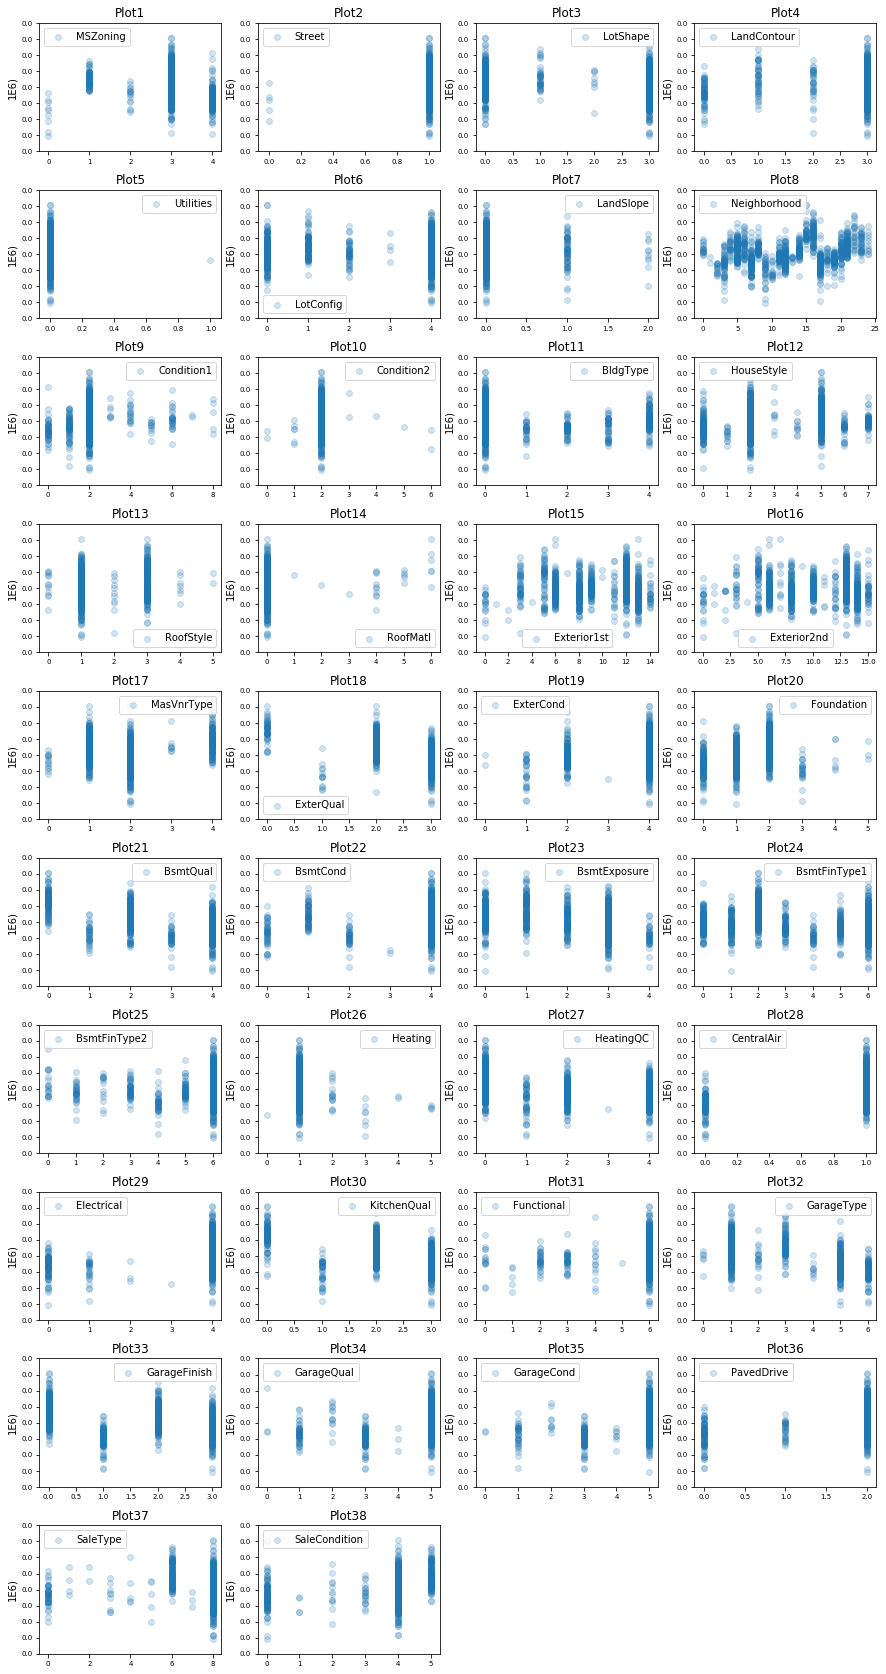

In [171]:
rows = int(np.ceil(len(cat_vars) / 4))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))
for i, col in enumerate(cat_vars):
    #print(col)
    axi = f.add_subplot(rows, 4, i+1)
    plt.scatter(train_num[col], train_num.SalePrice, label = col, alpha = 0.2)
    #df = train[[col, 'SalePrice']]
    #X = df.values
    #elenv = EllipticEnvelope(contamination=.001)
    #pred = elenv.fit_predict(X)
    #anom_index = np.where(pred==-1)
    #values = X[anom_index]

    #plt.scatter(values[:,0],values[:,1], color='r')
    plt.title("Plot" + str(i+1))
    axi.tick_params(axis="x", labelsize=7)
    axi.tick_params(axis="y", labelsize=7)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    plt.ylabel('1E6)')
    plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

In [151]:
listTransformCatVars_Bin = ["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "CentralAir", "Electrical", 
                               "KitchenQual", "Functional", "GarageType", "GarageFinish", "GarageQual", "GarageCond", 
                               "PavedDrive", "SaleType", "SaleCondition", "MSSubClass", "MSZoning", "Street" , "LotShape",
                               "LandContour", "Utilities" , "LotConfig" , "LandSlope" , "Neighborhood" , "Condition1" , 
                               "Condition2" , "BldgType" , "HouseStyle", "RoofStyle", "RoofMatl" , "Exterior1st" , 
                               "Exterior2nd" , "MasVnrType" , "ExterQual" , "ExterCond" , "Foundation" , "BsmtQual",
                               "BsmtCond", "HeatingQC"]
print(len(listTransformCatVars_Bin))

39


In [159]:
cat_vars.values.tolist()

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [139]:
cat_vars

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [80]:
df['MasVnrArea'].value_counts()

0.0         854
NotAvail      8
72.0          8
180.0         8
108.0         8
           ... 
748.0         1
234.0         1
731.0         1
230.0         1
510.0         1
Name: MasVnrArea, Length: 327, dtype: int64

In [27]:
df_correl = checkTargetVarCorrel(train)
print('Top {} features with direct correlation to target variable: '.format(20))
df_correl.head(20)

Top 20 features with direct correlation to target variable: 


,Var,Variable
0,OverallQual,0.82
1,GrLivArea,0.70
2,GarageCars,0.68
3,GarageArea,0.65
4,TotalBsmtSF,0.61
5,1stFlrSF,0.60
6,YearBuilt,0.59
7,FullBath,0.59
8,GarageYrBlt,0.59
9,YearRemodAdd,0.57


*There will most likely be some multicollinearity in this dataset due to similar features (i.e. Garage features). Similar features will be examined for collinearity and those with less correlation to the target variable but high levels of multicollinearity will be removed. A backup of the original datasets will be kept.*

In [25]:
train_old = train.copy() # backup

In [310]:
train = train_old.copy() # backup

- Examine 'Garage' variables

In [26]:
colLst = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colLst.append(col)
df_ = train[colLst]
checkVarInfFactor(df_)
checkPearsonCorrel(df_)

GarageYrBlt = 2.82, GarageCars = 5.14, GarageArea = 4.71, 

SalePrice  &  GarageType  with correlation coeff =  -0.5
SalePrice  &  GarageYrBlt  with correlation coeff =  0.59
SalePrice  &  GarageFinish  with correlation coeff =  -0.42
SalePrice  &  GarageCars  with correlation coeff =  0.68
SalePrice  &  GarageArea  with correlation coeff =  0.65
SalePrice  &  GarageQual  with correlation coeff =  0.28
SalePrice  &  GarageCond  with correlation coeff =  0.32


Drop 'GarageArea' and see if multicollinearity improves - 'GarageCond' does not appear to have multicollinearity with counterparts

In [312]:
train.drop(['GarageArea'], axis = 1, inplace = True)
colLst = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colLst.append(col)
df_ = train[colLst]
checkVarInfFactor(df_)

GarageYrBlt = 2.73, 



Remove 'GarageYrBlt' & risk of multicollinearity should be reduced

In [313]:
train.drop(['GarageYrBlt'], axis = 1, inplace = True)
colLst = ['SalePrice']
for i, col in enumerate(train):
        if 'Garage' in col:
            colLst.append(col)
df_ = train[colLst]
checkVarInfFactor(df_)

- Examine 'Bsmt' variables (Basement)

In [314]:
colLst = ['SalePrice']
for i, col in enumerate(train):
        if 'Bsmt' in col:
            colLst.append(col)
df_ = train[colLst]
checkVarInfFactor(df_)
checkPearsonCorrel(df_)

BsmtFinSF1 = 3.79, BsmtFinType2 = 3.83, BsmtFinSF2 = 4.39, BsmtUnfSF = 3.50, TotalBsmtSF = 3.11, 

SalePrice  &  BsmtFinSF1  with correlation coeff =  0.37
SalePrice  &  TotalBsmtSF  with correlation coeff =  0.45


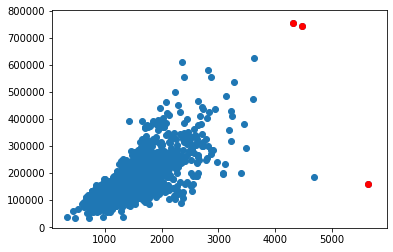

'\nprint(elenv)\n\nEllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,\n                 store_precision=True, support_fraction=None) \n\n\narr = cov.predict(X)\nplt.plot(arr, df.SalePrice)'

In [87]:
df = train[['GrLivArea', 'SalePrice']]
X = df.values
#cov = EllipticEnvelope(random_state=0).fit(X)
elenv = EllipticEnvelope(contamination=.002)
pred = elenv.fit_predict(X)


#Next, we'll extract the negative outputs as the outliers.

anom_index = np.where(pred==-1)
values = X[anom_index]


#Finally, we'll visualize the results in a plot by highlighting the anomalies with a color.

plt.scatter(X[:,0], X[:,1])
plt.scatter(values[:,0],values[:,1], color='r')
plt.show()

'''
print(elenv)

EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None) 


arr = cov.predict(X)
plt.plot(arr, df.SalePrice)'''

In [80]:
arr.shape

(1460,)

In [43]:
type(train.Id.dtype)

str

In [44]:
train.Id.dtype == 'int64'

True

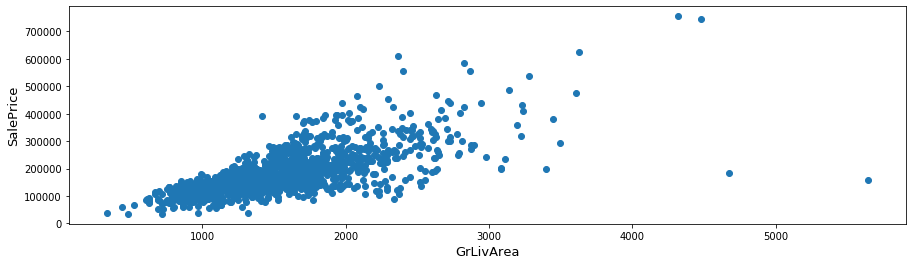

In [20]:
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [22]:
# Check higher variance inflation factors
def checkVarInfFactor(df):
    # For each X, calculate VIF and save in dataframe
    #array = df.values
    #X = array[:,1:(df.shape[1] - 1)]
    #Y = array[:,(df.shape[1] - 1)]
    #X = df.copy()
    df_ = df.drop(['SalePrice'], axis=1)
    X = add_constant(df_)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Display Features with High Variance Inflation Factor
    corrFeatures = []
    corrFeatures.append("SalePrice")
    for i in range(0, len(vif["features"] )):
        if vif["VIF Factor"][i] > 2.5 and vif["features"][i] != "const":
            print("{} = {:.2f}".format(vif["features"][i], vif["VIF Factor"][i]), end = ', ')   
            corrFeatures.append(vif["features"][i])
    print('\n')
            
# Check Pearson's correlation coefficient of variables without visualising entire heatmap
def checkPearsonCorrel(df):
    for i, feat in enumerate(df.columns):
        for j, feat_ in enumerate(df.columns):
            if (feat == 'SalePrice') & (feat_ != 'SalePrice'):
                pearson_coeff = round(pearsonr(df[feat], df[feat_])[0], 2)
                print(feat, " & ", feat_, " with correlation coeff = ",  pearson_coeff)

def checkTargetVarCorrel(df):
    lstCorrelRanks = []
    for i, col in enumerate(df):
        if col != 'SalePrice':
            #print(type(df[col].values[0]), col)
            pearson_coeff = round(pearsonr(df['SalePrice'], df[col])[0], 2)
            lstCorrelRanks.append([col, pearson_coeff])
            #print(col, pearson_coeff)
    df_correl = pd.DataFrame(lstCorrelRanks, columns = ['Var', 'Variable'])
    df_correl.sort_values(by = 'Variable', ascending = False, inplace = True)
    df_correl.reset_index(drop = True, inplace = True)
    return df_correl
            